# 2. Classification

In [58]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.activations import relu, selu
from tensorflow.keras.layers import Activation, LeakyReLU, PReLU
from tensorflow.keras.backend import clear_session

## Classification intro

### Supervised learning

- What is supervised learning?
- Training
- Fitting
- Labels
- Error / cost / objective functions

### Classification

Clasification is a type of 

- What is classification?
- Different approaches
  - Logistic regression - log loss
  - ANNs, SVMs
  - ...

### No free lunch

- Model selection.
- Parametric / nonparametric models.
- Discriminative / generative modelling.

A model is a simplified replica of the real world. This allows us to build and understand them with relative ease and use them to make predictions of future events. However these simplifations abstract away details, meaning the model cannot be a full representation of the real world and will therefore make mistakes. The abstraction level of your model creates a trade-off between performance and accuracy.

No free lunch theorum states that no model is guarenteed to work for all problems, all you can do is test and evaluate each to find a best solution.

### Overfitting

As a model is a abstraction, so are the patterns within it. It is easy to create a model to fit to data, with little effort you could create a model which accuratly predicts the training data's labels given the features. You could imagine this as creating a giant look-up table; when a training instance is given to the model it finds that combination of features in the table and returns the related label.

But what happens when a new set of features are given to the model it hasn't seen before? It wont have the exact result for the data and so it will make a wrong prediction. This phenomona of a model learning too well from the data it was trained on is called overfitting. This happens when the model learns the pattern in your abstraction rather than the pattern of the real problem. 

The aim is to build a model which generalises to the problem you are trying to solve. This way you can make predictions on unseen data and see the same results as you did whilst training.

### Training, testing and validation

Model training is the process of learning from data. In supervised learning we have labeled data and so we have a target to aim for. Data is given to the model and slowly it learns in different ways how to tune itself to reproduce the correct labels when given that data.

As discussed above it is not enough to predict the data it has learned from. To evaluate a model's real-world performance a model must be tested on 

### Cross-validation

- explain cross validation

### Optimisation

- Hyperparameters

#### Classification with MNIST

- The aim of classification with MNIST
- Get the data
- Recap analysis
  - Size, shape, type
  - Features
  - Missing data, outliers etc.
  - Target feature of dataset (class)

Download the MNIST dataset, getting features X and labels y:

In [ ]:
X, y = fetch_openml('mnist_784', return_X_y=True)

We shall look at the number of unique features in the dataset.

In [ ]:
n_classes = len(np.unique(y))
print(n_classes)

There appear to be 10 unique digit types.

We shall put the data into a NumPy array and analyse the shape of the data:

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Image shape: {X[0].shape}")

From the shape we can see that we have the full MNIST dataset of 70000 hand written didgets. 

They are yet to be split into a training and testing set and each image has been flattened to a (784,) array rather than the standard (28,28) form.

Now we shall have a look at the image data to see what form it is in.

In [ ]:
print(np.min(X[0]), np.max(X[0]))

Looking at the minimum and maximum values in appears that pixel are of the standard 0-255 intensity form. 

It is beneficial to some machine learning methods for values to be normalised between 0-1, notably neural networks so we shall do this in the data preparation step.

Finally we shall check the datatypes for features and labels.

In [ ]:
print(X.dtype)
print(y.dtype)

The features are of float type as expected but it may be beneficial to convert the string type labels to integers.

#### Preparing the data

  - train, val test sets
  - cross validation
  - reshape / retype

As stated earlier normalising the feature values will be beneficial for machine learning later on.

In [ ]:
X_full = X / 255.0
print(np.min(X_full), np.max(X_full))

We shall also now convert the string type features to integers for use later on.

In [ ]:
y_full = y.astype('int64')
print(y.dtype)

We will need to create a train, validation and test set before we proceed using sklearns `train_test_split`.

In [ ]:
# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)

# remove a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_full.shape[0])
print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

Now we can train the data and analyse using the validation set before testing on the test set. This will allow us to minimise overfitting by ensuring our model generalises well.

Later on we shall use cross-validation on the entire training set to ensure maximum generalisation, but for now we shall use the the validation set for this.

## 2.1 Artificial Neural Networks (ANNs)

### Neurons

- Neurons structure
- Action potentials ~ activation functions
- Weights, connections etc.

### The perceptron

- Perceptron history
- Input layer
- Output layer
- Activation function
- Weights
- Bias
- Try and apply it to MNIST (lots of neurons?)

In [ ]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

In [ ]:
perceptron.score(X_val, y_val)

### Perceptron regularisation

This is a reasonably good result for such a simple model, but this is due to the simplicity of the data set.

One way we can try and improve the results is through regularisation.

** **EXPLAIN REGULARISATION** **

As the model training doesn't take too long we shall try a grid search with `None`, `l1`, `l2` and `ElastiNet` regularisation.

We shall do this with 5-fold cross validation, evaluating the accuracy on the validation set.

In [ ]:
reg_perceptron = Perceptron(alpha=0.0001, tol=0.001,
                            max_iter=1000, early_stopping=True,
                            validation_fraction=0.1, n_iter_no_change=5,
                            random_state=42, verbose=0, n_jobs=-1)

perceptron_params = [{'penalty': ['None', 'l1', 'l2', 'elasticnet']}]

grid_search = GridSearchCV(reg_perceptron, perceptron_params,
                           scoring='accuracy', cv=5,
                           return_train_score=True,
                           verbose=3)

grid_search.fit(X_train, y_train)

We can now check the optimal parameters of the grid search.

In [ ]:
grid_search.best_params_

It appears l1 regularisation has produced the best results for the MNIST dataset.
- explain why this might be

### Multi-layer perceptron

- Multiple layers of neurons
- Able to learn more complex patterns

### Training MLPs

- Forward pass
- Backward pass
- Epochs, convergence

### Forward pass

- Calculation of outputs from input
- Calculates loss

### Backpropogation

- Gradient descent
- Learning rate
- Minimise loss function
- Convex optimisation problem
- Chain rule

### Stochastic gradient descent

- What is SGD
- Diagram

### Cross entropy

- What is cross entropy
- Sparse categorical cross entropy

### Classifying MNIST

- Feed forward network
- Dense layers
- Epochs, convergence
- Create a simple MLP for MNIST

In [ ]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=[784]))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))

Discuss validation / training results

### Analysing model training

We shall use Tensorboard to visualise our model results as well as analyse training.

We shall configure it to create a new subdirectory for each model instance.

In [ ]:
def get_tb_dir():
    curr_dir = os.path.join(os.curdir, "tensorboard_logs")
    tb_dir = time.strftime("model_%Y_%m_%d-%H-%M-%S")
    return os.path.join(curr_dir, tb_dir)

Now we can create a callback during model training for Tensorboard

In [ ]:
tensorboard = TensorBoard(get_tb_dir())

Fitting the model with the callback will then write the logs to it's own directory in `tensorboard_logs`.

In [ ]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=[784]))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard])

Now we can look at the Tensorboard logs

In [ ]:
# !kill 132185
# %reload_ext tensorboard
# %tensorboard --logdir=./tensorboard_logs --port=6006

- screenshot training over epochs
- discuss training over time
    - loss / accuracy change
    - learning rate

### Learning rate

- Analyse adjusting learning rate
- Learning rate schedling

In [ ]:
def create_lr_model(lr):
    model = Sequential()
    model.add(BatchNormalization(input_shape=[784]))
    model.add(Dense(100, activation="relu"))
    for i in range(20):
        model.add(BatchNormalization())
        model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=SGD(lr=lr, momentum=0.9), metrics=["accuracy"])

In [ ]:
np.random.seed(42)
lr_model = KerasClassifier(build_fn=create_model, epochs=10)
param_grid = {"lr": [0.001, 0.01, 0.1, 0.2]}

# grid search
lr_grid = GridSearchCV(act_model, param_grid, cv=2, verbose=0)
lr_grid_results = act_grid.fit(X_train, y_train,
                               validation_data=[X_val, y_val],
                               callbacks=[tensorboard, early_stopping],
                               verbose=0)

Lets see how the learning rate affecting training time and accuracy.

- multi-learning rate plot from tensorboard

Instead of using a set learning rate we can change it throughout training. I shall use exponential decay, where the learning rate starts high and decreases over time - the idea being that it will converge towards a solution quickly and then slow down learning so find an accurate solution.

We can implement this easily on the same model with Keras.

- learning rate scheduling model

Lets see how this affected the traininig

- multi-learning rate plot with lr scheduling model
- another plot for learning rate over epochs

Discussion of results -> using this method moving forward.

### Deeper neural networks

- Create a large overfitting network
- Early stopping, check pointing

- explain creating large model

In [ ]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=[784]))
for i in range(30):
    model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])
model.summary()

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard, early_stopping])

As we can see this large model with almost 400,000 parameters was a lot harder to train and generalised far worse on the validation set.

### Vanishing / exploding gradient problem

- What is the vanishing gradient problem
- Maybe ditch this ???
- Or just mention it as an option that is not needed for MNIST

I shall create a Keras wrapper in order to use Scikit's grid search.

With this wrapper we can search for params: 
- `kernel_initializer`: weigh and bias initialisation method
- `optimizer`: optimisation method used in back progogation
- `activation`: activation function used in forward pass
- `lr`: learning rate of the optimiser
- `momentum`: momentum of the optimiser

### Non-saturating activation functions

- Leaky RELU
- SELU

In [ ]:
# Return activation function as layer
def get_activation(activation):
    if (activation == 'relu'):
        return Activation(relu)
    elif (activation == 'selu'):
        return Activation(selu)
    elif (activation == 'leakyrelu'):
        return LeakyReLU()
    elif (activation == 'prelu'):
        return PReLU()
    return False

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # Sequential model
    model = Sequential()
    # Input layer with activation layer
    model.add(Dense(100, input_shape=[784]))
    model.add(get_activation(activation))
    # Hidden layers with activation function
    for i in range(21):
        model.add(Dense(50))
        model.add(get_activation(activation))
    # Output layer
    model.add(Dense(10, activation='sigmoid'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [ ]:
np.random.seed(42)
act_model = KerasClassifier(build_fn=create_model, epochs=10)
param_grid = {"activation": ['relu', 'selu', 'leakyrelu', 'prelu']}

# grid search
act_grid = GridSearchCV(act_model, param_grid, cv=2, verbose=0)
act_grid_results = act_grid.fit(X_train, y_train,
                                validation_data=[X_val, y_val],
                                callbacks=[tensorboard, early_stopping])

In [ ]:
act_grid_results.best_params_

### Batch normalisation

- Batch normalisation
- Mini-batch
- Implement batching

- explain batch normalisation

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=[784]))
model.add(Dense(100, activation="relu"))
for i in range(20):
    model.add(BatchNormalization())
    model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=[X_val, y_val],
                    callbacks=[tensorboard, early_stopping])

- show better generalisation results

### Optimisers

#### Momentum

- explain momentum

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=[784]))
model.add(Dense(100, activation="relu"))
for i in range(20):
    model.add(BatchNormalization())
    model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=SGD(momentum=0.9), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=[X_val, y_val],
                    callbacks=[tensorboard, early_stopping])

- discuss results of momentum
- show plots from tensorboard of trianing times?

#### Adaptive moment esitmation (Adam)

- Better optimisers
    - Adam

- overview of the adam optimiser

In [ ]:
adam_model = Sequential()
adam_model.add(Dense(100, activation="relu"))
adam_model.add(BatchNormalization(input_shape=[784]))
for i in range(20):
    adam_model.add(Dense(50, activation="relu"))
    adam_model.add(BatchNormalization())
adam_model.add(Dense(10, activation="softmax"))

adam_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer=Adam(), metrics=["accuracy"])

In [ ]:
clear_session()

history = adam_model.fit(X_train, y_train, epochs=20,
                         validation_data=[X_val, y_val],
                         callbacks=[tensorboard, early_stopping])

- training time / accuracy comparison to sgd

### Minibatches

- Explain minibatch optimisation
- Run the same model with batches

In [ ]:
clear_session()

history = adam_model.fit(X_train, y_train, epochs=20, batch_size=16,
                         validation_data=[X_val, y_val],
                         callbacks=[tensorboard, early_stopping])

- compare speed / accuracy with / without

### Overfitting in ANNs

- Why large networks can overfit
- l1, l2 loss and regularisation
- Implement regularisation
- Dropout, monte carlo dropout
- Create a network with dropout

In [ ]:
drop_model = Sequential()

drop_model.add(BatchNormalization(input_shape=[784]))
drop_model.add(Dense(100, activation="relu"))

for i in range(20):
    drop_model.add(Dense(50, activation="relu"))
    drop_model.add(BatchNormalization())

drop_model.add(Dense(50, activation="relu"))
drop_model.add(Dropout(rate=0.5))

drop_model.add(Dense(10, activation="softmax"))

drop_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer='sgd', metrics=["accuracy"])

In [ ]:
clear_session()

history = drop_model.fit(X_train, y_train, epochs=20,
                         validation_data=[X_val, y_val],
                         callbacks=[tensorboard, early_stopping])

- discuss results of dropout network

### Convolutional neural networks (CNN)

- Problems with neural networks and images
- Convolutions, filters
- Convolutional layers, feature maps
- Simple CNN for MNIST

- what are convolutions
- what are cnns

In [ ]:
# initial cnn model

- discuss and analyse performance vs normal model

### Training better CNNs

- Stride, step
- Pooling, max pooling
- Better CNN

- what are max pooling layers

In [ ]:
# cnn with max pooling

- discuss results
- bigger model

In [ ]:
# big cnn model

- discuss results
- likely reached maximum performance
- show missclassified iamges

### Limitations of ANNs

- Where ANNs dont work
- Where they are not needed
- Need lots of data etc.

## 2.2. Support Vector Machines (SVMs)

Train an SVM (with a chosen Kernel) and perform the same analyses as for ANNs. Interpret  and  discuss  your  results. Does the model overfit? How do they compare with ANNs? And why? How does the type of kernel (e.g.linear, RBF, etc.) impact on performance?

### Support vector machines

- Hyperplane
- Support vectors
- Minimising lagrange multiplier (MIT)

### Linear SVM

- Implementation of SVM on MNIST
- Plot decision boundaries from lab 2

Fit linear SVM to training data

In [19]:
linear_svm = LinearSVC(loss="squared_hinge", dual=False,
                       max_iter=1000, verbose=10)
linear_svm.fit(X_train, y_train)

[LibLinear]

LinearSVC(dual=False, verbose=10)

Test on validation set.

In [20]:
linear_svm.score(X_val, y_val)

0.909047619047619

### The dual problem

What is the dual problem

### Soft-margin classification

- What is soft-margin classification
- What is the C parameter

Grid search C parameter.

In [22]:
grid_linear_svm = LinearSVC(loss="squared_hinge", dual=False,
                            max_iter=1000)

c_params = {"C": [0.01, 0.1, 1, 10, 10]}

c_gridsearch = GridSearchCV(grid_linear_svm, c_params,
                            cv=2, verbose=3)

Fit grid search to train data with 3-fold cross validation

In [23]:
c_gridsearch.fit(X_train, y_train)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. C=0.01, score=0.903, total=   1.8s
[CV] C=0.01 ..........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV] .............................. C=0.01, score=0.904, total=   1.7s
[CV] C=0.1 ...........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] ............................... C=0.1, score=0.898, total=   2.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.903, total=   2.2s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.883, total=   3.3s
[CV] C=1 .............................................................
[CV] ................................. C=1, score=0.887, total=   3.5s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.866, total=   7.2s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.868, total=   8.1s
[CV] C=10 ............................................................
[CV] ................................ C=10, score=0.866, total=   7.2s
[CV] C=10 ............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   45.3s finished


GridSearchCV(cv=2, estimator=LinearSVC(dual=False),
             param_grid={'C': [0.01, 0.1, 1, 10, 10]}, verbose=3)

Results from grid search cross-validation.

In [24]:
c_gridsearch.best_params_

{'C': 0.01}

In [25]:
c_gridsearch.best_estimator_

LinearSVC(C=0.01, dual=False)

In [26]:
c_gridsearch.best_score_

0.9035978835978836

- discuss results from C hyper parameter tuning

### Kernels

- Different representations
- Kernels
- Mercer's theorem
- Gram matrix

### The kernel trick

- What is the kernel trick

### Kernel SVMs

- How kernel SVMs work

### Polynomial KSVM

- What is the polynomial kernel
- Implementation

In [27]:
poly_params = {"degree": [2, 3]}
grid_poly = SVC(kernel='poly', max_iter=1000)
poly_gridsearch = GridSearchCV(grid_poly, poly_params, cv=2)

In [28]:
poly_gridsearch.fit(X_train, y_train)

/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=2, estimator=SVC(kernel='poly', max_iter=1000),
             param_grid={'degree': [2, 3]})

Results from grid search cross-validation.

In [29]:
poly_gridsearch.best_params_

{'degree': 2}

In [30]:
poly_gridsearch.best_estimator_

SVC(degree=2, kernel='poly', max_iter=1000)

In [31]:
poly_gridsearch.best_score_

0.9544973544973545

It appears the 2nd degree polynomial kernel is a good fit, a 5% increase over the standard polynomial kernel.

### Radial basis function (RBF) KSVM

- What is the RBF kernel
- Implementation

In [34]:
rbf_params = {"gamma": [1, 5, 'scale', 'auto']}
grid_rbf = SVC(kernel='rbf', max_iter=5000)
rbf_gridsearch = GridSearchCV(grid_rbf, rbf_params, cv=2)

In [35]:
rbf_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(max_iter=5000),
             param_grid={'gamma': [1, 5, 'scale', 'auto']})

In [36]:
rbf_gridsearch.best_params_

{'gamma': 'scale'}

In [37]:
rbf_gridsearch.best_estimator_

SVC(max_iter=5000)

In [38]:
rbf_gridsearch.best_score_

0.9579365079365079

It seems the RBF kernel has performed similarly to the polynomial kernel.

### Sigmoid KSVM

- What is the sigmoid kernel
- Implementation

In [46]:
sigmoid_params = {"gamma": [1, 5, 10, 'scale', 'auto']}
grid_sigmoid = SVC(kernel='sigmoid', max_iter=5000)
sigmoid_gridsearch = GridSearchCV(grid_sigmoid, sigmoid_params, cv=2)

In [47]:
sigmoid_gridsearch.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=SVC(kernel='sigmoid', max_iter=5000),
             param_grid={'gamma': [1, 5, 10, 'scale', 'auto']})

In [48]:
sigmoid_gridsearch.best_params_

{'gamma': 'auto'}

In [49]:
sigmoid_gridsearch.best_estimator_

SVC(gamma='auto', kernel='sigmoid', max_iter=5000)

In [50]:
sigmoid_gridsearch.best_score_

0.9051851851851852

Results seem similar to that of the linear SVM.

#### Analysis of kernels

It seems kernel SVMs have provided extra accuracy, with the RBF and 2nd degree polynomial kernel performing the best in the gridsearch. I suspect with some additional searching we could find the optimal kernel parameters.

- confusion_matrix
- precision_score, 
- recall_score
- f1_score
- roc_curve
- roc_auc_score

In [53]:
svm_gs = [c_gridsearch, poly_gridsearch, rbf_gridsearch, sigmoid_gridsearch]
svms = [gs.best_estimator_ for gs in svm_gs]
svm_preds = [svm.predict(X_test) for svm in svms]

I shall create a dataframe to collect results

In [55]:
results = pd.DataFrame(columns=["precision_score", "recall_score", "f1_score"])

In [56]:
svm_cms = [confusion_matrix(preds, y_test) for (svm, preds) in zip(svms, svm_preds)]

Text(0.5, 1.0, 'Confusion Matrix for Sigmoid Kernel SVM')

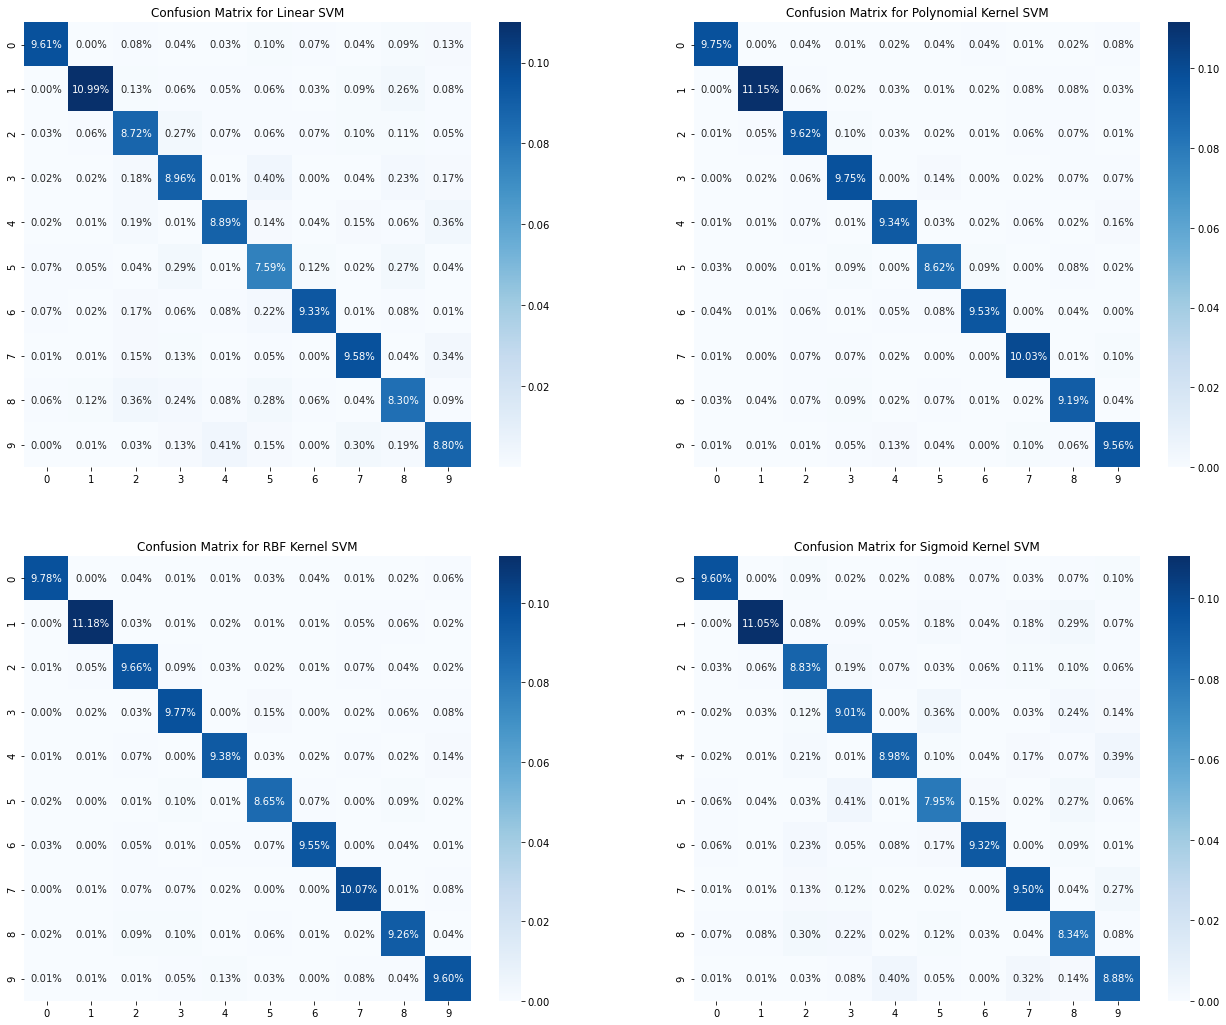

In [73]:
fig, ax = plt.subplots(figsize=(22, 18))

plt.subplot(221)
fig1 = sns.heatmap(svm_cms[0]/np.sum(svm_cms[0]), annot=True,
                   fmt='.2%', cmap='Blues')
fig1.set_title("Confusion Matrix for Linear SVM")

plt.subplot(222)
fig1 = sns.heatmap(svm_cms[1]/np.sum(svm_cms[1]), annot=True,
                   fmt='.2%', cmap='Blues')
fig1.set_title("Confusion Matrix for Polynomial Kernel SVM")

plt.subplot(223)
fig1 = sns.heatmap(svm_cms[2]/np.sum(svm_cms[2]), annot=True,
                   fmt='.2%', cmap='Blues')
fig1.set_title("Confusion Matrix for RBF Kernel SVM")

plt.subplot(224)
fig1 = sns.heatmap(svm_cms[3]/np.sum(svm_cms[3]), annot=True,
                   fmt='.2%', cmap='Blues')
fig1.set_title("Confusion Matrix for Sigmoid Kernel SVM")

In [96]:
reports = [classification_report(pred, y_test) for pred in svm_preds]

In [97]:
for (report, svm) in zip(reports, ["Linear", "Polynomial", "RBF", "Sigmoid"]):
    print(svm, "SVM:\n", report, "\n")

Linear SVM:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      4999
           1       0.97      0.93      0.95      5764
           2       0.87      0.91      0.89      4677
           3       0.88      0.89      0.89      4923
           4       0.92      0.90      0.91      4843
           5       0.84      0.89      0.86      4177
           6       0.96      0.93      0.94      4926
           7       0.92      0.93      0.92      5060
           8       0.86      0.86      0.86      4716
           9       0.87      0.88      0.88      4915

    accuracy                           0.91     49000
   macro avg       0.91      0.91      0.91     49000
weighted avg       0.91      0.91      0.91     49000
 

Polynomial SVM:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      4902
           1       0.99      0.97      0.98      5633
           2       0.96      0.96      0.96   

- discuss results
- probably better to just analyse the RBF kernel
- or just do accuracy and leave for comparison below

### Limitations of SVMs

From the

## Classification conclusion

#### Comparison of ANNs and SVMs

- Comparison of neural networks and support vector machines.
- Area under ROC curve
- Precision, recall, accuracy...
- TP, TN, FP, FN and rates for each
- Confusion matrix
- Metric
- Validation
- Cross-validation
- Prediction
- Inference
- Interpretability
- Sensitivity vs specificity

- above metrics for CNN model and RBF kernel SVM
- maybe compare FF-ANN and the linear SVM as well